<a href="https://colab.research.google.com/github/jongbinny98/ucsc/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE - 144 Assignment 4

## Due: June 7, 2022 11:59 pm


**Be sure to set your Runtime environment to include a GPU, as it will speed up the training considerably (this time that's important!).**

Intro Slides: https://docs.google.com/presentation/d/1PjqwL9g8XPr40LLRjRAAtxzc4Tf9iqVVnq61gJ59_Iw/edit?usp=sharing

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Ignore the warnings - Otherwise, TensorFlow tends to innundate one with far too many warnings.
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn

# Configure some defaults.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# ML + Deep Learning Imports
import tensorflow as tf
from keras import backend as k
from tensorflow import keras
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator # Data Augmentation
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models 
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.models import Sequential # This building the models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop 
from tensorflow.keras.utils import to_categorical # if label is 0,1,...,99 etc then it becomes [0,...1,.,0] a len 100 vector
from keras.callbacks import ReduceLROnPlateau #learning rate decay policy
from sklearn.model_selection import train_test_split # for splitting data



 

import numpy as np
import pandas as pd # for making our csv
import time
# Image preprocessing and reading in.
import imageio 
from pathlib import Path
import os, sys
from zipfile import ZipFile


#### Step-0: Import dataset
Download Tiny-ImageNet-100 dataset using the code blocks below. 

Please fill in the code block below to split the data into training, validation and test datasets you may use scikit-learn to split.

In [33]:
# Download Tiny-Imagenet-100
!gdown 1bn9RtCsMu-v_ZagKCK2z7hVEDOIjb9Pd

for file in os.listdir(os.getcwd()):
    if file.endswith(".zip"):
        zip = ZipFile(file)
        zip.extractall()
    else:
        print("not found")

Downloading...
From: https://drive.google.com/uc?id=1bn9RtCsMu-v_ZagKCK2z7hVEDOIjb9Pd
To: /content/tiny-image-net-100.zip
100% 139M/139M [00:00<00:00, 315MB/s]
not found
not found
not found
not found
not found
not found


In [34]:
path = 'tiny-image-net-100/'

def get_id_dictionary():
    """
    Maps each class id to an unique integer.
    """
    id_dict = {}
    for i, line in enumerate(open(path + 'wnids.txt', 'r')):
        id_dict[line.rstrip('\n')] = i
    return id_dict
  
def get_class_to_id_dict():
    """
    Maps each class id to the English version of the label.
    """
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict, n_samples = 500):
    """
    n_samples: number of samples per class. n_samples has a max of 500.
    The range is [1, 500].
    """
    print('starting loading data')
    train_data, test_data = [], []
    train_labels = []
    t = time.time()
    for key, value in id_dict.items():
      if value<100: # Only focus on first 100 classes
        train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(n_samples)]
        train_labels_ = np.array([[0]*100]*n_samples)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    test_image_names = []
    path_list = list(Path(path+'test/images/').glob('*.jpg'))
    for test_image_path in path_list:
        img_name = str(test_image_path).split('.')[0][-18:]
        test_image_names.append(img_name)
        test_data.append(imageio.imread(test_image_path , pilmode='RGB'))
        
    print('finished loading data, in {} seconds'.format(time.time() - t))

    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    test_data = np.array(test_data)

    return train_data, train_labels, test_data, test_image_names

In [35]:
###### Your codes start here.######

# Start with n_samples = 10 to get your code working and then increase accordlingy.
id_dict = get_id_dictionary()
train_data, train_labels, test_data, test_image_names = get_data(id_dict)
x_test, test_size = test_data, 0.1
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size = test_size)


###### Your codes end here.######
print( "train data shape: ",  x_train.shape )
print( "train label shape: ", y_train.shape )
print( "val data shape: ",  x_val.shape )
print( "val label shape: ", y_val.shape )
print( "test data shape: ",   x_test.shape )

starting loading data
finished loading data, in 18.754961729049683 seconds
train data shape:  (45000, 64, 64, 3)
train label shape:  (45000, 100)
val data shape:  (5000, 64, 64, 3)
val label shape:  (5000, 100)
test data shape:  (5000, 64, 64, 3)


In [36]:
# Let's set some random seeds to make this more reproducible.
def setseeds():
  np.random.seed(137)
  rn.seed(137)
  tf.random.set_seed(137)
setseeds()

#### Step-1: Data Preparation & Exploration

Let's take a look at a few of these images. Rerun this cell multiple times to see different images for each class.

You may notice that these images look low fidelity, which is because they are! As we increase our image size, we also increase our model complexity. What's important is that our classes are still distinguishable from each other.

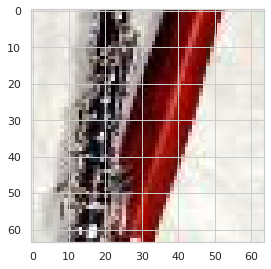

In [37]:
#Visulize one image from Tiny-ImageNet
plt.imshow(x_train[0], cmap=plt.cm.binary)

#### Step-2: Build a neural network.
Build your convolutional neural networks by adding some layers. You should use 2 convolution layers and ReLU as the default activation function.
Add max pooling after the first layer.
The kernel size of both layers should be 3x3. Use 32 and 64 as the number of filters for the first and the second convolutional layers, respectively. After that, flatten your input and add two more dense layers. There should be 1024 units in the first dense with ReLU activation, and use 100 hidden units in the second dense layer with softmax activation.

In [38]:
# build convolutional neural network
###### Normalizing. ######
# x_train = x_train / 255.0
# x_val = x_val / 255.0
# # x_test = x_test / 255.0

# resModel = keras.applications.ResNet50(include_top=False,
#                                        weights="imagenet",
#                                        input_shape=(224, 224, 3))


In [39]:
###### Your code starts here. ######
#define our CNN architecture, using karas
# This is where we define the architecture of our deep neural network.
model = tf.keras.Sequential()

model.add(Conv2D(filters = 32, 
          kernel_size=(3, 3), 
          activation=PReLU())
          )

model.add(Conv2D(filters = 64, 
          kernel_size=(3, 3), 
          activation=PReLU())
          )

model.add(MaxPooling2D((2, 2), strides=2))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, 
          kernel_size=(3, 3), 
          activation=PReLU())
          )
model.add(MaxPooling2D((2, 2), strides=2))
model.add(BatchNormalization())


model.add(Conv2D(filters = 256, 
          kernel_size=(3, 3), 
          activation=PReLU())
          )

model.add(MaxPooling2D((2, 2), strides=2))

model.add(Conv2D(filters = 512, 
          kernel_size=(3, 3), 
          activation=PReLU())
          )
model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(1024, activation = PReLU()))  

model.add(Dense(100, activation = "softmax"))
# model = tf.keras.Sequential()

# model.add(Conv2D(filters = 32,      
#                  kernel_size = (3, 3), 
#                  activation = PReLU()
#                  ))

# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 64,      
#                  kernel_size = (3, 3), 
#                  activation = PReLU()
#                  ))

# model.add(MaxPooling2D(pool_size = (2, 2)))

# model.add(Flatten())

# model.add(Dropout(0.5))

# model.add(Dense(1024, activation = PReLU()))  

# model.add(Dense(100, activation = "softmax"))

###### Your codes end here.######

### Side Note: How to save a model to google drive


In [40]:
# Mount colab to your drive
# from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [41]:
# Add load model if exists

In [42]:
# Save your model to gdrive
# model.save('/content/drive/My Drive/hw4 kaggle/hw4_model.h5')  

In [43]:
# load a model
# Returns a compiled model identical to the previous one, if you load you don't need to model.compile()
# model = load_model('/content/drive/My Drive/hw4 kaggle/hw4_model.h5') 

#### Step-3: Train the model
Compile model here and set your initial hyperparameters. Use ADAM as the optimizer. You should choose 'categorical_crossentropy' as your loss function, and the metrics should be 'accuracy'. After that, train your model for 30 epochs. 

In [44]:
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-3)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        123904    
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        248896    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       174208    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)     

In [45]:
### Your code here###
#compile the model
model.compile(optimizer = Adam(lr = 0.001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
### Your code here###

### Data Augmentation

There are many augmentations you can use! Read about them in the Keras documentation.

 **Rescale is very important!**

In [46]:
# Set up data generators for training and validation set
# add transformations

datagen = ImageDataGenerator(
          rescale=1/255.,
          featurewise_center=False,           # set input mean to 0 over the dataset
          samplewise_center=False,            # set each sample mean to 0
          featurewise_std_normalization=False,# divide inputs by std of the dataset
          samplewise_std_normalization=False, # divide each input by its std
          zca_whitening=False,                # apply ZCA whitening
          rotation_range=0,                   # randomly rotate images in the range (degrees, 0 to 180)
          width_shift_range=0.1,              # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,             # randomly shift images vertically (fraction of total height)
          horizontal_flip=True,               # randomly flip images
          vertical_flip=True)               # randomly flip images


valid_datagen = ImageDataGenerator(rescale=1/255.)

In [47]:
### Your code here ###

# fit generators to datasets
datagen.fit(x_train)
valid_datagen.fit(x_val)

### Your code here###

In [ ]:
## Your Code Here ###

#set number of epochs, set batch_size
nb_epoch = 50
batch_size= 32

# # Fit the model on the batches generated by datagen.flow().
# setseeds()

# history = model.fit(x_train, y_train,
#                     batch_size = batch_size,
#                     epochs = nb_epoch, 
#                     validation_data = (x_val, y_val)
#                     )
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
         validation_data = valid_datagen.flow(x_val, y_val, batch_size = batch_size),
         steps_per_epoch=len(x_train) / 32, epochs=nb_epoch)



Epoch 1/50
1017/1406 [====================>.........] - ETA: 13s - loss: 4.4601 - accuracy: 0.0272

### Plot Model Performance

In [ ]:
# Plot Model Performance
### YOUR CODE HERE ###

def plot_data(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

plot_data(history)

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
# Make Submission Kaggle File
def create_submission_file(model):
  name2idx = {}
  sample_submission = pd.read_csv('tiny-image-net-100/submission_sample.csv')
  filename_order = sample_submission['img_id'].values
  for i in range(len(filename_order)):
    name2idx[filename_order[i]] = i

  # Google colab reads the files in a different order than the answer file was created.
  # This is done to preserve the file order.
  result_dict = {'img_id': [None]*len(x_test),
                'label':[None]*len(x_test)}
  test_preds = np.argmax(model.predict(x_test/255.),axis=-1)

  for i in range(len(test_image_names)):
    test_image_name = test_image_names[i]
    result_dict['img_id'][name2idx[test_image_name]] = test_image_name
    result_dict['label'][name2idx[test_image_name]] = test_preds[i]

  pd.DataFrame(result_dict).to_csv('submission.csv', index=False)

In [ ]:
# Create your submission file and download it.
create_submission_file(model)


You made it this far! You may have noticed your accuracy is not that great to improve on it do the following:

i) Design a more complex neural network architecture. (Transfer learning may help)

ii) Utilize data augmentation during training.


Experiment often and save your models. 

When you are satisfied submit your predictions to Kaggle. 

Good luck!